# Image Classification with CNN using Keras

# Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Preprocess Data

In [2]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Visualize Examples

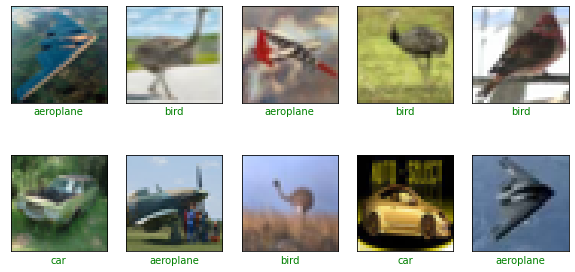

In [4]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace = False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
    plt.show();


show_random_examples(x_train, y_train, y_train)
        

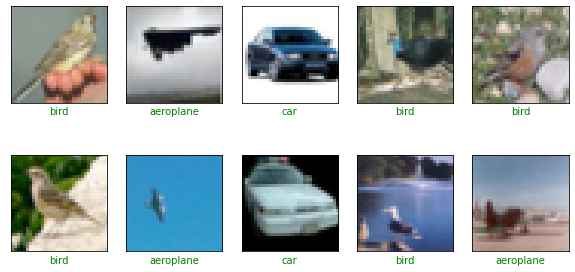

In [5]:
show_random_examples(x_test, y_test, y_test)

# Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [7]:
def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Train the Model

In [8]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor = 'val_accuracy'        
        )
    ]
)

Epoch 1/10
118/118 [==============================] - 82s 694ms/step - loss: 0.9312 - accuracy: 0.6669 - val_loss: 2.7039 - val_accuracy: 0.3340
Epoch 2/10
118/118 [==============================] - 76s 645ms/step - loss: 0.5451 - accuracy: 0.7814 - val_loss: 2.4866 - val_accuracy: 0.5340
Epoch 3/10
118/118 [==============================] - 79s 673ms/step - loss: 0.4787 - accuracy: 0.8067 - val_loss: 1.3242 - val_accuracy: 0.5223
Epoch 4/10
118/118 [==============================] - 89s 755ms/step - loss: 0.4396 - accuracy: 0.8251 - val_loss: 0.7956 - val_accuracy: 0.6930
Epoch 5/10
118/118 [==============================] - 75s 635ms/step - loss: 0.4039 - accuracy: 0.8418 - val_loss: 0.5569 - val_accuracy: 0.7917
Epoch 6/10
118/118 [==============================] - 74s 630ms/step - loss: 0.3654 - accuracy: 0.8565 - val_loss: 0.7967 - val_accuracy: 0.7543
Epoch 7/10
118/118 [==============================] - 76s 641ms/step - loss: 0.3433 - accuracy: 0.8647 - val_loss: 0.3363 - val_ac

# Final Predictions

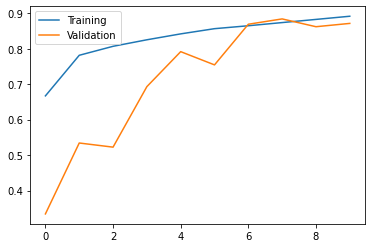

In [9]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [10]:
model = tf.keras.models.load_model('models/model_0.884.h5')

In [11]:
preds = model.predict(x_test/255.)

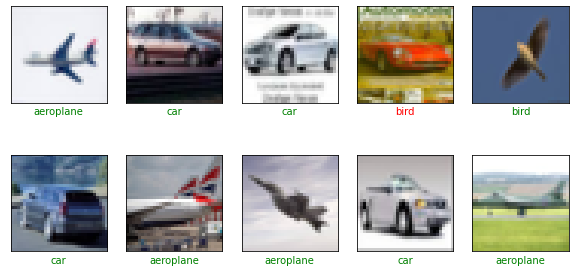

In [13]:
show_random_examples(x_test, y_test, preds)